<a href="https://colab.research.google.com/github/philip-papasavvas/ml_sandbox/blob/main/Natural_Language_Processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Natural Language Processing (NLP) Project using the SMS Spam dataset**

The following project will look at applying machine learning techniques, specifically for a natural language processing problem. The problem will focus on using SMS message data, curated from the UCI Machine Learning repository. The dataset contains almost 5,600 text messages in English, and are labelled with either ham (the text is not spam), or spam.

In this project we will explore concept such as: 
* **Lemmaisation**: this involves converting each word into its base form, for example by removing its ending. Converting the word running to run is an example of lemmaisation.
* **Bag of words**: This approach uses a collection of words to represent a sentence, taking account of the number of occurences of each word.

The data used in this project can be found here:
* https://archive.ics.uci.edu/ml/datasets/sms+spam+collection

This workbook will have the following outline:
1. **Exploratory Data Analysis**
2. **Data pre-processing & cleaning**
3. **Overview of feature selection methods**
4. **Lemmaisation**
4. **Testing the different models**

## 1. Exploratory Data Analysis
First, import the modules needed and load the data. Then, explore the statistics of the underlying data, such as the split between spam/non-spam (ham) messages and the length of the messages.

In [134]:
import pandas as pd
import numpy as np
import string

import matplotlib.pyplot as plt
import seaborn as sns
sns.set() # set seaborn as default style even if we use matplotlib

# text preprocessing
import nltk

%matplotlib inline

In [70]:
# import the SMS text file
sms_messages = pd.read_csv(
    'https://raw.githubusercontent.com/philip-papasavvas/ml_sandbox/main/data/SMSSpamCollection.txt',
    sep='\t', names=['label', 'message'])

In [71]:
print(f"{len(sms_messages[sms_messages['label'] == 'ham'])} non-spam messages \n"
      f"{len(sms_messages[sms_messages['label'] != 'ham'])} spam messages")

4825 non-spam messages 
747 spam messages


We can see that there are considerably more non-spam than spam messages. We need to ensure that later on, when training the model we adjust the sample to have a 50% split between spam/non-spam to train the model.

In [72]:
sms_messages.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


Having inspected the dataset, it would be useful to add some more features to the data, such as the **length** of each message and the **number of words**. It's important that we understand the data well, to have the ability to add more features. This will enable us to carry out feature engineering more effectively. This is extremely important in the field of natural language processing (and spam classification), where feature engineering is one of the most important parts of the process.

In [73]:
sms_messages['length'] = sms_messages['message'].apply(len)
sms_messages['word_count'] = [len(x.split()) for x in sms_messages["message"]]

In [74]:
sms_messages.groupby('label').describe()

length                                                           \
        count        mean        std   min    25%    50%    75%    max   
label                                                                    
ham    4825.0   71.482487  58.440652   2.0   33.0   52.0   93.0  910.0   
spam    747.0  138.670683  28.873603  13.0  133.0  149.0  157.0  223.0   

      word_count                                                      
           count       mean        std  min   25%   50%   75%    max  
label                                                                 
ham       4825.0  14.310259  11.517945  1.0   7.0  11.0  19.0  171.0  
spam       747.0  23.911647   5.780174  2.0  22.0  25.0  28.0   35.0

Add in a histogram for the length, and word count, split by spam and non-spam.

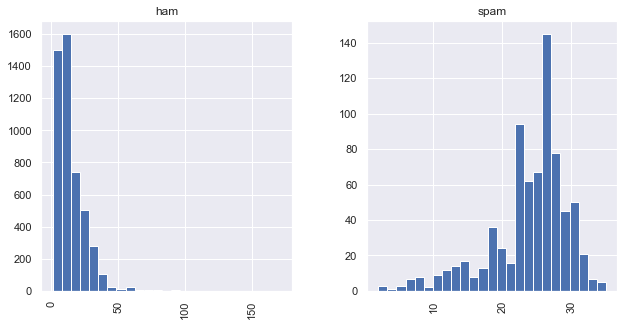

In [82]:
hist_plt = sms_messages.hist(column='word_count', by='label', figsize=(10,5), bins=25)


### Inspecting the word_count and length of the messages

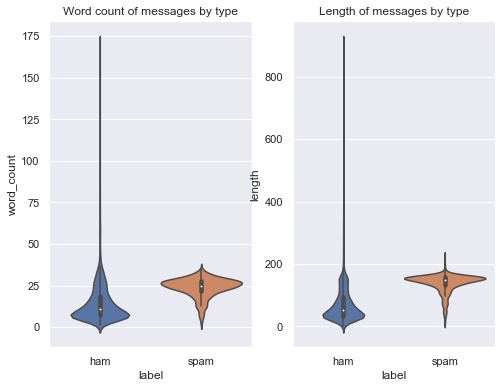

In [126]:
fig = plt.figure(figsize=(8,6))

ax1 = fig.add_subplot(121)
ax1.set_title("Word count of messages by type")
g = sns.catplot(data=sms_messages, y='word_count', x='label',
           kind='violin', split=True, ax=ax1)

ax2 = fig.add_subplot(122)
ax2.set_title("Length of messages by type")
g = sns.catplot(data=sms_messages, x='label', y='length',
                kind='violin', split=True, ax=ax2)

plt.close(2)
plt.close(3)

Therefore, from the above, for:
- word_count: non-spam messages have many fewer words than the spam messages. On average the non-spam messages contain around 10 words, with the spam messaged containing around 25 words. The dispersion between the non-spam messages is much larger than the spam messages, with an outlier of almost 200 words in a message!
- length: spam messages tend to be much longer, whilst the ham messages are much shorter. Again, the dispersion of the data for the non-spam is much greater than the spam messages.

We cna also confirm the above intuitions using the *describe* method. Let's demonstrate this for the non-spam messages

In [123]:
print("Non-spam messages, length statistics \n")
sms_messages[sms_messages['label'] == 'ham'].describe().T

Non-spam messages, length statistics 



,count,mean,std,min,25%,50%,75%,max
length,4825.0,71.482487,58.440652,2.0,33.0,52.0,93.0,910.0
word_count,4825.0,14.310259,11.517945,1.0,7.0,11.0,19.0,171.0


## 2. Data pre-processing
The data consists of many different text as a sequence of strings, whilst there might be some words in the overall dataset that share the same meaning, for example 'running' and 'run'. The underlying meaning of these words is the same, and we will use this fact later in a process called **lemmaisation** to reduce the overall number of words in the population of all the SMS messages.

Furthermore, machine learning algorithms in general are optimised for use with vectors, so we will extract the features from these messages into a series of numerical feature vectors. To start with, let's inspect a couple of the texts and see what pre-processing we should perform on the data.

In [129]:
sms_messages['message'][10]

"I'm gonna be home soon and i don't want to talk about this stuff anymore tonight, k? I've cried enough today."

In [133]:
sms_messages.loc[sms_messages['label'] == 'spam', 'message'].head()

2     Free entry in 2 a wkly comp to win FA Cup fina...
5     FreeMsg Hey there darling it's been 3 week's n...
8     WINNER!! As a valued network customer you have...
9     Had your mobile 11 months or more? U R entitle...
11    SIX chances to win CASH! From 100 to 20,000 po...
Name: message, dtype: object

It's quite cleaer that punctuation doesn't give us too much insight into whether a message is spam or not, and common words (the, a, there, etc.) appearing in the English language (stopwords) do not give much away regarding if the messages are spam or not. Furthemore, we will convert all text to lowercase, to further reduce the word population. We will write functions to:
* remove punctuation
* remove stopwords - we wil make use of the **corupus** package within the **nltk** package to do so.

In [139]:
from nltk.corpus import stopwords # common words

english_stopwords = stopwords.words('english')
len(english_stopwords)

179

We can see that overall there are 179 stopwords! These can be removed from the dataset to reduce each message and will ensure smaller feature vectors for use in our machine learning model. Now let's construct a function to remove punctuation from a text, as well as removing the stopwords, and test the function afterwards.

In [143]:
def clean_text(txt: str) -> list:
  """Method to clean input text (list)"""
  # remove punctuation from the list
  no_punc = [char for char in txt if char not in string.punctuation]
  
  # join the chaaracters with no punctuation to get the original words
  no_punc = "".join(no_punc)

  # remove stopwords
  return [word for word in no_punc.split() if word not in english_stopwords]

clean_text(sms_messages['message'][10])

['Im',
 'gonna',
 'home',
 'soon',
 'dont',
 'want',
 'talk',
 'stuff',
 'anymore',
 'tonight',
 'k',
 'Ive',
 'cried',
 'enough',
 'today']

We saw earlier the original text has been reduced in size from a string, to a list of strings (words).

We will go ahead and apply this **clean_text** function to all of our messages.

In [145]:
sms_messages['cleaned_message'] = sms_messages['message'].apply(clean_text)

Let's compare the cleaned text to the orignal DataFrame:

## 3. Overview of feature selection methods
There are many different ways to look at the features of the text message data:
* **tokenisation**: we have converted the original text strings into lists of tokens (meaningful words that are free of stopwords and punctuation)
* **stemming**: this is the process of reducing a word to its word stem/root form. This is where you would remove affixes to a word, such as  An example of this are ed, -ize, -s, etc. Stems are created when the suffixes/prefixes are removed from the word. Converting our list of words into stems will then give us a vector that we can use with machine learning libraries such as **scikit-learn**.